In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
#!pip install datasets
#!pip install transformers
#!pip install 'accelerate>=0.26.0'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [1]:
from datasets import load_dataset
dataset = load_dataset("derek-thomas/ScienceQA")
validation_data = dataset["validation"]
validation_data

/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 4241
})

### This is a normal datapoint

In [2]:
validation_data[3500]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x202>,
 'question': 'Is diorite a mineral or a rock?',
 'choices': ['rock', 'mineral'],
 'answer': 0,
 'hint': 'Diorite has the following properties:\nno fixed crystal structure\nnaturally occurring\nnot a pure substance\ncoarse-grained texture\nsolid\nnot made by organisms',
 'task': 'closed choice',
 'grade': 'grade8',
 'subject': 'natural science',
 'topic': 'earth-science',
 'category': 'Rocks and minerals',
 'skill': 'Identify rocks and minerals',
 'lecture': 'Minerals are the building blocks of rocks. A rock can be made of one or more minerals.\nMinerals and rocks have the following properties:\nProperty | Mineral | Rock\nIt is a solid. | Yes | Yes\nIt is formed in nature. | Yes | Yes\nIt is not made by organisms. | Yes | Yes\nIt is a pure substance. | Yes | No\nIt has a fixed crystal structure. | Yes | No\nYou can use these properties to tell whether a substance is a mineral, a rock, or neither.\nLook closely at t

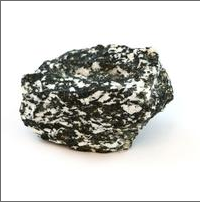

In [3]:
validation_data[3500]["image"]

### This is an abnormal datapoint with no image
But the text is enough to figure out the solution

In [5]:
validation_data[0]

{'image': None,
 'question': "What does the verbal irony in this text suggest?\nAccording to Mr. Herrera's kids, his snoring is as quiet as a jackhammer.",
 'choices': ['The snoring is loud.', 'The snoring occurs in bursts.'],
 'answer': 0,
 'hint': '',
 'task': 'closed choice',
 'grade': 'grade8',
 'subject': 'language science',
 'topic': 'figurative-language',
 'category': 'Literary devices',
 'skill': 'Interpret figures of speech',
 'lecture': 'Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.\nVerbal irony involves saying one thing but implying something very different. People often use verbal irony when they are being sarcastic.\nOlivia seems thrilled that her car keeps breaking down.\nEach breakdown is as enjoyable as a punch to the face.',
 'solution': "The text uses verbal irony, which involves saying one thing but implying something very different.\nAs quiet as a jackhammer suggests that the snoring 

### This is a bad abnormal datapoint
Image is part of the task input and is missing. The solution is also missing.

In [6]:
validation_data[4240]

{'image': None,
 'question': 'What information supports the conclusion that Rick inherited this trait?',
 'choices': ["Rick's coworker also has curly hair.",
  "Rick's biological father has curly hair.",
  'Rick and his biological parents have brown hair.'],
 'answer': 1,
 'hint': 'Read the description of a trait.\nRick has curly hair.',
 'task': 'closed choice',
 'grade': 'grade7',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Genes to traits',
 'skill': 'Inherited and acquired traits: use evidence to support a statement',
 'lecture': "Organisms, including people, have both inherited and acquired traits. Inherited and acquired traits are gained in different ways.\nInherited traits are passed down from biological parents to their offspring through genes. Genes are pieces of hereditary material that contain the instructions that affect inherited traits. Offspring receive their genes, and therefore gain their inherited traits, from their biological parents. Inherited 

## Filter Data

In [2]:
filtered_validation_data = validation_data.filter(lambda example: example["lecture"] != "" and example["solution"] != "")
filtered_validation_data

Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 3216
})

# Experiment with Models

In [3]:
import torch

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps"
device

'mps'

In [5]:
from abc import ABC, abstractmethod

class Model(ABC):
    """Abstract base class for models with custom processing."""

    def __init__(self, model_name: str):
        self.model_name = model_name
        self.model = self.load_model()
        self.processor = self.load_processor()

    @abstractmethod
    def load_model(self):
        """Load the model architecture and weights."""
        pass

    @abstractmethod
    def load_processor(self):
        """Load the processor associated with the model."""
        pass

    @abstractmethod
    def process(self, *args, **kwargs):
        """Define the processing logic for the model."""
        pass

## Preliminary Experiments

In [8]:
class LLaVAModel(Model):
    def load_model(self):
        from transformers import LlavaForConditionalGeneration
        return LlavaForConditionalGeneration.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True)

    def load_processor(self):
        from transformers import AutoProcessor
        return AutoProcessor.from_pretrained(self.model_name)

    def process(self, text_input, image, **kwargs):
        # Workaround for "Expanding inputs for image tokens in LLaVa-NeXT should be done in processing."
        # from https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf/discussions/34
        self.processor.patch_size = self.model.config.vision_config.patch_size
        self.processor.vision_feature_select_strategy = self.model.config.vision_feature_select_strategy

        # Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
        # Each value in "content" has to be a list of dicts with types ("text", "image")
        conversation = [
            {
              "role": "user",
              "content": [
                  {"type": "text", "text": text_input},
                  {"type": "image"},
                ],
            },
        ]
        prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
        inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)
        self.model = self.model.to(device)
        with torch.no_grad():
          output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
          response = self.processor.decode(output[0][2:], skip_special_tokens=True)

        print(f"\nPrompt:\n {prompt}")
        print(f"\nModel response:\n {response}")
        return response

In [9]:
models = {
    "LLaVAModel1.5-7b": LLaVAModel("llava-hf/llava-1.5-7b-hf")
}

/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warnin

### Prompt LLaVa with a chat setting
- additional user-defined instruction: `You are a helpful assistant. Answer the user's request to the best of your knowledge.`
- output format instruction: `Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}`

**Notes**:
- (?) possibility of empty responses of ASSISTANT (e.g. first example, `QTCHL` setting) -- why?
- (!) output format instruction `Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}` actually resulted in `ASSISTANT: {"answer": "choice number", "solution": "your step-by-step thinking"}` in some cases.
- in other cases the format was correct, although the answer is different from the golden answer (and the model can actually justify its reasoning with some plausible) -- could this be the result of "the best of your knowledge"?

In [ ]:
n = 3500
#QCMIT
def process_datapoint(model, n):
  system_prompt = "You are a helpful assistant. Answer the user's request to the best of your knowledge."
  question = validation_data[n]["question"]
  context = validation_data[n]["hint"]
  choice = validation_data[n]["choices"]
  image = validation_data[n]["image"]
  task = validation_data[n]["task"]
  lecture = validation_data[n]["lecture"]
  solution = validation_data[n]["solution"]
  prompt_answer_and_solution = '\nSolve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}'
  prompt_answer_only = '\nSolve task. Return JSON: {"answer": "choice number"}'

  # text_input = f"Question: {question}\nContext: {context}\nOptions: {choice}\nTask: {task}"
  # QTCH
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHL
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHLS
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_only}"
  model.process(text_input=text_input, image=image)

In [ ]:
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.



Prompt:
 USER: <image>
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT:

Model response:
 ER:  
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT: {"answer": "mineral", "s

In [ ]:
n = 2400
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT:

Model response:
 ER:  
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutr

In [ ]:
# won't work since the image is none
# n = 1500
# model = models["LLaVAModel1.5-7b"]
# process_datapoint(model, n)

### Prompt LLaVa with a chat setting (2)
- no additional user instruction (as there is already one handled implicitly by `self.processor.apply_chat_template(conversation, add_generation_prompt=True)` above at model definition
- output format instruction: `\nPlease output the answer in JSON style with an answer and a solution field`

**Notes**:
- some answers are still empty, but for the rest -
- **now, the answers are correct**! Diorite is now a rock, not a mineral! Was it really because of the "to the best of your knowledge" part, or is the output format instruction also infuencing the generation?
- in any case, the model returns the answer and not its index, which is a bit disapointing as it is not directly following the instruction.

In [ ]:
def process_datapoint(model, n):
  question = validation_data[n]["question"]
  context = validation_data[n]["hint"]
  choice = validation_data[n]["choices"]
  image = validation_data[n]["image"]
  task = validation_data[n]["task"]
  lecture = validation_data[n]["lecture"]
  solution = validation_data[n]["solution"]
  prompt_answer_and_solution = '\nPlease output the answer in JSON style with an answer and a solution field'

  # text_input = f"Question: {question}\nContext: {context}\nOptions: {choice}\nTask: {task}"
  # QTCH
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHL
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHLS
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHS
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)

In [ ]:
n = 3500
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT:

Model response:
 ER:  
Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT: {
"answer": "rock",
"solution": "Diorite is a rock, not a mineral. It is a coarse-grained, solid, naturally occurring substance that has no fixed crystal structure and is not made by organisms."
}

Prompt:
 USER: <image>
Question: Is di

In [ ]:
n = 2400
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT:

Model response:
 ER:  
Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Please output the answer

In [ ]:
# won't work since no image
#n = 1500
#model = models["LLaVAModel1.5-7b"]
#process_datapoint(model, n)

# Process whole Dataset

## Simple 1 by 1 GPU processing

This version processes datapoints one at a time, mapping the function process function to dataset. 

**Running on Colab note**: `map`ping would exhaust RAM limits on Colab really quickly - swith to for loop there (although for loop is slower than map). 

**Running on MacBook note**: caching on `mps` can be weird, adding assets to memory after every processed datapoint, resulting in n times the model size in memory. Remember to clear cache every once in a while (e.g. after processing one setting). 

### Define Process Functions

In [12]:
import csv
import os
import pandas as pd
from collections import defaultdict

setting_templates = {
    "QTCH": "Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}",
    "QTCHL": "Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}",
    "QTCHLS": "Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_and_solution}",
    "QTCHS": "Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nSolution: {solution}\n Instruction: {prompt_answer_and_solution}",
}

# Helper function to save each processed result to the appropriate CSV
def save_to_csv(setting, model_name, entry):
    # results_save_path = f"/content/drive/MyDrive/foundation_models/benchmarking/{model_name}"
    results_save_path = f"./benchmarking/{model_name}"
    os.makedirs(results_save_path, exist_ok=True)

    file_path = f"{results_save_path}/{model_name}_val_output_setting_{setting}.csv"
    df = pd.DataFrame([entry])  # Single-row DataFrame for appending
    with open(file_path, 'a') as f:
        df.to_csv(f, header=f.tell()==0, index=False, sep="\t", quoting=csv.QUOTE_ALL)  # Write header if file is empty

def process_datapoint_at_setting(example, idx, setting, model_name, resumed_index_from):
    model = models[model_name]
    image = example["image"]
    subject = example["subject"]
    prompt_answer_and_solution = '\nPlease output the answer in JSON style with an answer and a solution field'

    text_input = setting_templates[setting].format(
        question=example["question"], 
        task=example["task"], 
        choice=example["choices"], 
        context=example["hint"], 
        lecture=example["lecture"], 
        solution=example["solution"], 
        prompt_answer_and_solution=prompt_answer_and_solution)
    answer = model.process(text_input=text_input, image=image)
    if answer == "NA":
        print(idx, setting, text_input)
    entry = {"idx": resumed_index_from+idx, "input": text_input, "output": answer, "subject": subject}
    save_to_csv(setting, model_name, entry)

### LLaVA 1.5

Redefine LLaVAModel Class
- to handle unexpected inputs: image None; error handling; keep track of unprocessed ids as `self.failed_indices`
- as defined above, it is better not to introduce additional "system" prompts, so no "instruction" from user is provided
- output format instruction: `'\nPlease output the answer in JSON style with an answer and a solution field'`
- Note: might it be a better idea to include format instructions into the model class as prompt parts can be model specific?

In [6]:
import torch
from PIL import Image

class LLaVAModel(Model):
    def __init__(self, model_name: str, verbose: bool = False):
        super().__init__(model_name)  # Initialize the base Model class
        self.verbose = verbose
        self.failed_indices = []  # Track indices of data points that fail processing

    def load_model(self):
        from transformers import LlavaForConditionalGeneration
        return LlavaForConditionalGeneration.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )

    def load_processor(self):
        from transformers import AutoProcessor
        return AutoProcessor.from_pretrained(self.model_name)
    
    def process_batch(self, text_inputs, images, indices, **kwargs):
        pass

    def process(self, text_input, image, index=None, **kwargs):

        # Set up processor configurations
        self.processor.patch_size = self.model.config.vision_config.patch_size
        self.processor.vision_feature_select_strategy = self.model.config.vision_feature_select_strategy

        # Try processing inputs to catch any issues early on
        try:
            ignore_image_flag = "" # no flag if there is an image given
            if not image:
                # create empty small image because this is a required argument at the current version of the model 
                image = Image.new('RGB', (10, 10), color='white')
                ignore_image_flag = "\nIgnore image\n"

            conversation = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": text_input + ignore_image_flag}, # flag if image is a blank placeholder to prevent hallucinations
                        {"type": "image"}, 
                    ],
                },
            ]
            prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
            inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)

        except Exception as e:
            # Catch any processing-related errors
            if index is not None:
                self.failed_indices.append(index)
                print(f"Processing failed at index {index}: {e}")
            else:
                print(f"Processing failed: {e}")
            return "NA"

        # Set model to device and perform inference
        self.model = self.model.to(device)
        try:
            with torch.no_grad():
                output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
                full_response = self.processor.decode(output[0][2:], skip_special_tokens=True)
            response = full_response.split("ASSISTANT:")[1]  # Extract chat response

            if self.verbose:
                print(f"\nPrompt:\n {prompt}")
                print(f"\nModel response:\n {response}")

            if response:
                return response
            else:
                print(full_response)
                return "NA"

        except Exception as e:
            # Catch any errors during model inference
            if index is not None:
                self.failed_indices.append(index)
                print(f"Inference failed at index {index}: {e}")
            else:
                print(f"Inference failed: {e}")
            return "NA"

In [7]:
models = {
    "LLaVAModel1.5-7b": LLaVAModel("llava-hf/llava-1.5-7b-hf")
}

/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/i.kuryanov/miniforge3/envs/katja/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warnin

#### inside look

In [27]:
# This cell checks that the processor can correctly generate inputs from blank image

image = Image.new('RGB', (10, 10), color='white') #336 crop_size height and width, but anyway padded with 32000 (or 1.9307?)
text = 'Why is the sky blue? Ignore image'
conversation = [
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": text},
                            {"type": "image"},
                        ],
                    },
                ]
p = models["LLaVAModel1.5-7b"].processor
prompt = p.apply_chat_template(conversation, add_generation_prompt=True)
inputs = p(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)
print(inputs)
# models["LLaVAModel1.5-7b"].processor()

model = models["LLaVAModel1.5-7b"].model.to(device)
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    response = p.decode(output[0][2:], skip_special_tokens=True)
response = response.split("ASSISTANT:")[1]  # Extract chat response
print(response)

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13, 11008,   338,
           278, 14744,  7254, 29973, 18076,   487,  1967,   319,  1799,  9047,
         13566, 29901]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='mps:0'), 'pixel_values': tensor([[[[1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307],
          [1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307],
          [1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307],
          ...,
          [1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307],
          [1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307],
          [1.9307, 1.9307, 1.9307,  ..., 1.9307, 1.9307, 1.9307]],

         [[2.0742, 2.0742, 2.0742,  ..., 2.0742, 2.0742, 2.0742],
          [2.0742, 2.0742, 2.0742,  ..., 2.0742, 2.0742, 2.0742],
          [2.0742, 2.0742, 2.0742,  ..., 2.0742, 2.0742, 2.0742],
          ...,
          [2.0742, 2.0742

#### Process with LLaVA 1.5  

In [ ]:
resume_index = 0 #index of last processed datapoint to resume interrupted execution; 0 to process whole dataset
filtered_validation_data.shard(num_shards=1, index=0).select(range(resume_index,len(filtered_validation_data)-1)).map(lambda example, idx: process_datapoint_at_setting(example, idx, "QTCHS", model_name="LLaVAModel1.5-7b", resumed_index_from=resume_index), with_indices=True)

Map: 100%|██████████| 1601/1601 [2:56:48<00:00,  6.63s/ examples]  


Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 1601
})

In [ ]:
resume_index = 0
filtered_validation_data.shard(num_shards=1, index=0).select(range(resume_index,len(filtered_validation_data)-1)).map(lambda example, idx: process_datapoint_at_setting(example, idx, "QTCHLS", model_name="LLaVAModel1.5-7b", resumed_index_from=resume_index), with_indices=True)

Map: 100%|██████████| 1601/1601 [3:32:22<00:00,  7.96s/ examples]  


Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 1601
})

In [ ]:
resume_index = 0
filtered_validation_data.shard(num_shards=1, index=0).select(range(resume_index,len(filtered_validation_data)-1)).map(lambda example, idx: process_datapoint_at_setting(example, idx, "QTCHL", model_name="LLaVAModel1.5-7b", resumed_index_from=resume_index), with_indices=True)

Map: 100%|██████████| 1600/1600 [3:46:17<00:00,  8.49s/ examples]  


Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 1600
})

In [17]:
torch.mps.empty_cache()

In [ ]:
resume_index = 0
filtered_validation_data.shard(num_shards=1, index=0).select(range(resume_index,len(filtered_validation_data)-1)).map(lambda example, idx: process_datapoint_at_setting(example, idx, "QTCH", model_name="LLaVAModel1.5-7b", resumed_index_from=resume_index), with_indices=True)

Map: 100%|██████████| 1303/1303 [2:01:51<00:00,  5.61s/ examples] 


Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 1303
})

### mPLUG

https://github.com/X-PLUG/mPLUG-Owl

"`mPLUG-Owl3` is a state-of-the-art multi-modal large language model designed to tackle the challenges of long image sequence understanding.
We propose Hyper Attention, which boosts the speed of long visual sequence understanding in multimodal large language models by sixfold, allowing for processing of visual sequences that are eight times longer.
Meanwhile, we maintain excellent performance on single-image, multi-image, and video tasks." -- from HuggingFace

In [19]:
#!pip install icecream

In [20]:
#!pip install einops

In [49]:
import torch
class mPLUG(Model):
    def __init__(self, model_name: str, verbose: bool = False):
        super().__init__(model_name)  # Initialize the base Model class
        self.verbose = verbose

    def load_model(self):
        # from transformers import mPLUGOwl3Model
        # model = mPLUGOwl3Model.from_pretrained(self.model_name, attn_implementation='sdpa', torch_dtype=torch.half) # what is sdpa? alternative: flash_attention_2
        from transformers import AutoModel
        model = AutoModel.from_pretrained(self.model_name, attn_implementation='sdpa', torch_dtype=torch.half, trust_remote_code=True)
        return model.eval()

    def load_processor(self):
        from transformers import AutoTokenizer, AutoProcessor
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        processor = self.model.init_processor(self.tokenizer)
        return processor


    def process(self, text_input, image, **kwargs):
        # Try processing inputs to catch any issues early on
        try:
            if image:
                conversation = [
                  {
                      "role": "user",
                      "content": f"""<|image|> {text_input}."""
                  },
                  {
                      "role": "assistant",
                      "content": ""
                  }
                ]
                print("Obtaining inputs with self.processor")
                inputs = self.processor(conversation, images=[image], videos=None)

                inputs = inputs.to(device)
                print(f"Type(inputs): {type(inputs)}")
                inputs.update({
                  'tokenizer': self.tokenizer,
                #   'max_new_tokens': 100,
                  'decode_text': True,
                })

            else:
                conversation = [
                    {
                        "role": "user",
                        "content": text_input,
                    },
                    {
                      "role": "assistant",
                      "content": ""
                    }
                ]
                inputs = self.processor(conversation, images=None, videos=None)

                inputs = inputs.to(device)
                inputs.update({
                  'tokenizer': self.tokenizer,
                #   'max_new_tokens': 100,
                  'decode_text': True,
                })

        except Exception as e:
            # Catch any processing-related errors
            if self.verbose:
                print(f"Processing failed: {e}")
            return None

        # Set model to device and perform inference
        self.model = self.model.to(device)
        try:
            with torch.no_grad():
                output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
                response = self.processor.decode(output[0], skip_special_tokens=True)

            if self.verbose:
                print(f"\nPrompt:\n {text_input}")
                print(f"\nModel response:\n {response}")

            return response

        except Exception as e:
            # Catch any errors during model inference
            if self.verbose:
                print(f"Inference failed: {e}")
            return None

In [50]:
# 7b (larger)
#models["mPLUG/mPLUG-Owl3-7B-240728"] = mPLUG("mPLUG/mPLUG-Owl3-7B-240728")

In [51]:
# 2b (earlier and smaller)
# recreate dict to unload LLaVAModel from memory -- no longer needed
models = {
    "mPLUG-Owl3-2B-241014": mPLUG("mPLUG/mPLUG-Owl3-2B-241014")
}

In [52]:
models["mPLUG-Owl3-2B-241014"].verbose=True

In [53]:
example = filtered_validation_data[10]
process_datapoint_at_setting(example, 10, 'QTCHL', "mPLUG-Owl3-2B-241014", 0)

Obtaining inputs with self.processor
Type(inputs): <class 'transformers_modules.mPLUG.mPLUG-Owl3-2B-241014.77ab9a6fdb9dae9ce2cd2eda3d32c8ff45ebc7db.image_processing_mplugowl3.mPLUGOwl3BatchFeature'>


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


Inference failed: 'Qwen2TokenizerFast' object has no attribute 'bos_id'


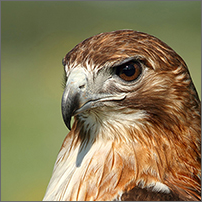

In [45]:
filtered_validation_data[10]["image"]

In [44]:
process_datapoint(models["mPLUG/mPLUG-Owl3-2B-241014"], 2400, verbose=True)

Obtaining inputs with self.processor
Type(inputs): <class 'transformers_modules.mPLUG.mPLUG-Owl3-2B-241014.77ab9a6fdb9dae9ce2cd2eda3d32c8ff45ebc7db.image_processing_mplugowl3.mPLUGOwl3BatchFeature'>


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


Inference failed: 'Qwen2TokenizerFast' object has no attribute 'bos_id'
Obtaining inputs with self.processor
Type(inputs): <class 'transformers_modules.mPLUG.mPLUG-Owl3-2B-241014.77ab9a6fdb9dae9ce2cd2eda3d32c8ff45ebc7db.image_processing_mplugowl3.mPLUGOwl3BatchFeature'>
Inference failed: 'Qwen2TokenizerFast' object has no attribute 'bos_id'
Obtaining inputs with self.processor
Type(inputs): <class 'transformers_modules.mPLUG.mPLUG-Owl3-2B-241014.77ab9a6fdb9dae9ce2cd2eda3d32c8ff45ebc7db.image_processing_mplugowl3.mPLUGOwl3BatchFeature'>
Inference failed: 'Qwen2TokenizerFast' object has no attribute 'bos_id'
Obtaining inputs with self.processor
Type(inputs): <class 'transformers_modules.mPLUG.mPLUG-Owl3-2B-241014.77ab9a6fdb9dae9ce2cd2eda3d32c8ff45ebc7db.image_processing_mplugowl3.mPLUGOwl3BatchFeature'>
Inference failed: 'Qwen2TokenizerFast' object has no attribute 'bos_id'


### BLIP-2

Bootstrapping Language-Image Pretraining: Vision and language Transformer model with efficient vision encoder and text-based decoder.

"BLIP-2 consists of 3 models: a CLIP-like image encoder, a Querying Transformer (Q-Former) and a large language model.

The authors initialize the weights of the image encoder and large language model from pre-trained checkpoints and keep them frozen while training the Querying Transformer, which is a BERT-like Transformer encoder that maps a set of "query tokens" to query embeddings, which bridge the gap between the embedding space of the image encoder and the large language model.

The goal for the model is simply to predict the next text token, giving the query embeddings and the previous text." -- from HuggingFace

HF has a separate processor and model loader for this family of models: https://huggingface.co/docs/transformers/main/en/model_doc/blip-2#transformers.Blip2ForConditionalGeneration.forward.example

In [ ]:
import torch
from transformers import Blip2ForConditionalGeneration, Blip2Processor

class Blip2Model(Model):
    def __init__(self, model_name: str, verbose: bool = False):
        super().__init__(model_name)  # Initialize the base Model class
        self.verbose = verbose

    def load_model(self):
        # Load Blip-2 model with low CPU memory usage
        return Blip2ForConditionalGeneration.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            device_map="auto"
        )

    def load_processor(self):
        # Load processor specific to Blip-2 model
        return Blip2Processor.from_pretrained(self.model_name)

    def process(self, text_input, image, **kwargs):
        # Set up processor configurations and device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(device)

        try:
            # Prepare inputs based on whether an image is provided
            if image:
                inputs = self.processor(
                    image,
                    text_input,
                    return_tensors="pt"
                ).to(device, torch.float16)
            else:
                inputs = self.processor(
                    text=text_input,
                    return_tensors="pt"
                ).to(device, torch.float16)

        except Exception as e:
            # Handle errors in processing
            if self.verbose:
                print(f"Processing failed: {e}")
            return None

        try:
            # Perform inference with the model
            with torch.no_grad():
                output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
                response = self.processor.decode(output[0], skip_special_tokens=True)

            # Log the output if verbose mode is enabled
            if self.verbose:
                print(f"\nPrompt:\n{text_input}")
                print(f"\nModel response:\n{response}")

            return response

        except Exception as e:
            # Handle errors during model inference
            if self.verbose:
                print(f"Inference failed: {e}")
            return None

In [ ]:
# BLIP-2 model, leveraging Flan T5-xl (a large language model).
# It was introduced in the paper BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models by Li et al.
# models["Salesforce/blip2-flan-t5-xl"] = Blip2Model("Salesforce/blip2-flan-t5-xl")

In [ ]:
# fine-tuned on COCO
models["Salesforce_blip2_opt_2_7B_coco"] = Blip2Model("Salesforce/blip2-opt-2.7b-coco")

In [ ]:
idx = 2500
example = filtered_validation_data[idx]
process_datapoint_at_setting(example, idx, "QTCH", model_name="Salesforce_blip2_opt_2_7B_coco", resumed_index_from=resume_index)

In [ ]:
resume_index = 0 #index of last processed datapoint to resume interrupted execution; 0 to process whole dataset
filtered_validation_data.shard(num_shards=1, index=0).select(range(resume_index,len(filtered_validation_data)-1)).map(lambda example, idx: process_datapoint_at_setting(example, idx, "QTCH", model_name="Salesforce_blip2_opt_2_7B_coco", resumed_index_from=resume_index), with_indices=True)